# Set up basics

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, LSTMCell, RNN, Reshape
from keras.callbacks import EarlyStopping
from keras import initializers, Model
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
# import plotly.offline as py
# import plotly.graph_objs as go
# py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
data = pd.read_csv('/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data_0401(6hrs).csv')
data.columns = ['scrape_time','lastUpdateId','bp_1','bz_1','bp_2','bz_2','bp_3','bz_3','bp_4','bz_4','bp_5','bz_5','bp_6','bz_6','bp_7','bz_7','bp_8','bz_8','bp_9','bz_9','bp_10','bz_10','bp_11','bz_11','bp_12','bz_12','bp_13','bz_13','bp_14','bz_14','bp_15','bz_15','bp_16','bz_16','bp_17','bz_17','bp_18','bz_18','bp_19','bz_19','bp_20','bz_20','ap_1','az_1','ap_2','az_2','ap_3','az_3','ap_4','az_4','ap_5','az_5','ap_6','az_6','ap_7','az_7','ap_8','az_8','ap_9','az_9','ap_10','az_10','ap_11','az_11','ap_12','az_12','ap_13','az_13','ap_14','az_14','ap_15','az_15','ap_16','az_16','ap_17','az_17','ap_18','az_18','ap_19','az_19','ap_20','az_20']
data.drop(['lastUpdateId'], axis=1, inplace= True)

In [3]:
## Drop scrape_time and create scrape_time_diff

data['scrape_time_interval'] = pd.to_datetime(data['scrape_time']).diff().dt.total_seconds()
data.drop(['scrape_time'], axis=1, inplace= True)

In [4]:
##################### Basic Feature Creation ##################
### Weighted Average Price 
data['WAP'] = (data['bp_1']*data['bz_1']
               +data['bp_2']*data['bz_2']
               +data['ap_1']*data['az_1']
               +data['ap_2']*data['az_2'])/(data['bz_1']+
                                         data['bz_2']+
                                         data['az_1']+
                                         data['az_2'])

#### Spread
data['spread'] = ((data['ap_1']/data['bp_1']) - 1)

### Log price
def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

### Log returns
data['log_returns'] = data.log_price.diff()

### Realized Volatility
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

data['realized_volatility'] = realized_volatility()

### Future volatility
data['volatility_t+1'] = data['realized_volatility'].shift(-1)

### Bid quantities
data['bid depth'] = data[['bz_1', 'bz_2', 'bz_3','bz_4', 'bz_5', 'bz_6','bz_7', 'bz_8', 'bz_9','bz_10',
                         'bz_11', 'bz_12', 'bz_13','bz_14', 'bz_15', 'bz_16','bz_17', 'bz_18', 'bz_19','bz_20']].sum(axis=1)


#sum of all bid quantities
data['ask depth'] = data[['az_1', 'az_2', 'az_3','az_4', 'az_5', 'az_6','az_7', 'az_8', 'az_9','az_10',
                         'az_11', 'az_12', 'az_13','az_14', 'az_15', 'az_16','az_17', 'az_18', 'az_19','az_20']].sum(axis=1)

In [5]:
df = data.copy()

In [6]:
data.drop(['bp_1','bp_2','bp_3','bp_4','bp_5','bp_6','bp_7','bp_8','bp_9','bp_10','bp_11','bp_12','bp_13','bp_14','bp_15','bp_16','bp_17','bp_18','bp_19','bp_20',
          'bz_1','bz_2','bz_3','bz_4','bz_5','bz_6','bz_7','bz_8','bz_9','bz_10','bz_11','bz_12','bz_13','bz_14','bz_15','bz_16','bz_17','bz_18','bz_19','bz_20',
          'ap_1','ap_2','ap_3','ap_4','ap_5','ap_6','ap_7','ap_8','ap_9','ap_10','ap_11','ap_12','ap_13','ap_14','ap_15','ap_16','ap_17','ap_18','ap_19','ap_20',
            'az_1','az_2','az_3','az_4','az_5','az_6','az_7','az_8','az_9','az_10','az_11','az_12','az_13','az_14','az_15','az_16','az_17','az_18','az_19','az_20'],axis=1, inplace=True)
          

In [7]:
data = data.iloc[3:-1,:].reset_index()
data.drop(['index'], axis=1, inplace= True)

df = df.iloc[3:-1,:].reset_index()
df.drop(['index'], axis=1, inplace= True)

# Creation

In [8]:
# 1. ob_weighted_price
def weighted_price(bid_prices, ask_prices, bid_sizes, ask_sizes):
    total_size = sum(bid_sizes) + sum(ask_sizes)
    if total_size == 0:
        return None
    bid_sum = sum([bid_prices[i] * bid_sizes[i] for i in range(len(bid_prices))])
    ask_sum = sum([ask_prices[i] * ask_sizes[i] for i in range(len(ask_prices))])
    return (bid_sum + ask_sum) / total_size

ob_weighted_price_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    ob_weighted_price = weighted_price(bid_prices, ask_prices, bid_sizes, ask_sizes)
    ob_weighted_price_list.append(ob_weighted_price)
    
data['ob_weighted_price'] = ob_weighted_price_list

In [9]:
# 2. EMA
# 3. SMA

SMA_list = []
EMA_list = []


for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    closing_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    
    # Calculate a 12-period simple moving average
    periods = 12
    sma = np.mean(closing_prices[-periods:])
    SMA_list.append(sma)
    
    # Create a pandas DataFrame with the closing prices
    df_ema = pd.DataFrame({"Close": closing_prices})
    ema = df_ema["Close"].ewm(span=periods, adjust=False).mean().iloc[-1]
    EMA_list.append(ema)


data['SMA'] = SMA_list
data['EMA'] = EMA_list

In [10]:
# 4. TWAP


TWAP_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    total_bid_volume = sum(bid_sizes)
    total_ask_volume = sum(ask_sizes)

    # Initialize variables for TWAP calculation
    twap_numerator = 0
    twap_denominator = 0
    time_interval = 60  # in seconds
    total_time = time_interval * len(bid_prices)

    # Calculate TWAP
    for i in range(len(bid_prices)):
        mid_price = (bid_prices[i] + ask_prices[i]) / 2
        volume = min(bid_sizes[i], ask_sizes[i])
        twap_numerator += mid_price * volume * time_interval
        twap_denominator += volume * time_interval

    TWAP = twap_numerator / twap_denominator
    TWAP_list.append(TWAP)
    
data['TWAP'] = TWAP_list

In [11]:
# 5. price_level
data['price_level'] = (df['bp_1'] + df['ap_1'])/2

# Autoregressive LSTM for results in the next 50 secs

In [47]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Define the number of time steps to use for each sample
n_lags = 10

# Create input and output data for the LSTM model
def create_dataset(df, n_lags):
    X, y = [], []
    for i in range(n_lags, len(df)):
        X.append(df.iloc[i-n_lags:i, 0])
        y.append(df.iloc[i, 0])
    return np.array(X), np.array(y)

In [48]:
X, y = create_dataset(data[['volatility_t+1']], n_lags)

In [49]:
# Split the data into training and testing sets
train_size = int(0.7 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [50]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_lags, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [51]:
# Train the mode
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
201/201 [==============================] - 1s 1ms/step - loss: 1.2360e-06
Epoch 2/100
201/201 [==============================] - 0s 2ms/step - loss: 3.1862e-11
Epoch 3/100
201/201 [==============================] - 0s 1ms/step - loss: 3.4815e-11
Epoch 4/100
201/201 [==============================] - 0s 1ms/step - loss: 3.3601e-11
Epoch 5/100
201/201 [==============================] - 0s 1ms/step - loss: 3.7289e-11
Epoch 6/100
201/201 [==============================] - 0s 1ms/step - loss: 4.0605e-11
Epoch 7/100
201/201 [==============================] - 0s 1ms/step - loss: 4.2597e-11
Epoch 8/100
201/201 [==============================] - 0s 2ms/step - loss: 5.0599e-11
Epoch 9/100
201/201 [==============================] - 0s 1ms/step - loss: 5.2453e-11
Epoch 10/100
201/201 [==============================] - 0s 1ms/step - loss: 7.3453e-11
Epoch 11/100
201/201 [==============================] - 0s 1ms/step - loss: 1.2639e-10
Epoch 12/100
201/201 [==============================

201/201 [==============================] - 0s 1ms/step - loss: 2.1734e-09
Epoch 96/100
201/201 [==============================] - 0s 1ms/step - loss: 1.4821e-09
Epoch 97/100
201/201 [==============================] - 0s 1ms/step - loss: 1.1042e-09
Epoch 98/100
201/201 [==============================] - 0s 1ms/step - loss: 1.6502e-09
Epoch 99/100
201/201 [==============================] - 0s 1ms/step - loss: 1.6583e-09
Epoch 100/100
201/201 [==============================] - 0s 1ms/step - loss: 1.5324e-09


In [52]:
# Evaluate the model on the testing set
loss = model.evaluate(X_test, y_test)
print('Test loss:', loss)

86/86 [==============================] - 0s 546us/step - loss: 1.8007e-09
Test loss: 1.8007493274296849e-09


In [53]:
# Make predictions on the testing set
predictions = model.predict(X_test)

86/86 [==============================] - 0s 520us/step


In [54]:
# Make predictions on the next 5670 targets
last_sample = X[-1].reshape(1, n_lags, 1)
predictions_all = []
for i in range(20):
    prediction = model.predict(last_sample)
    predictions_all.append(prediction[0][0])
    last_sample = np.concatenate((last_sample[:, 1:, :], prediction.reshape(1, 1, 1)), axis=1)

# Print the predictions
print('Predictions for the next 20 targets:')
print(predictions_all)

1/1 [==============================] - 0s 6ms/step
Predictions for the next 20 targets:
[-5.0836425e-06, -4.998412e-06, -5.021757e-06, -5.0748567e-06, -5.1250227e-06, -5.16165e-06, -5.1838415e-06, -5.1943334e-06, -5.1966144e-06, -5.1938114e-06, -5.18828e-06, -5.188369e-06, -5.1883926e-06, -5.188387e-06, -5.188371e-06, -5.18836e-06, -5.1883526e-06, -5.1883544e-06, -5.188347e-06, -5.1883508e-06]


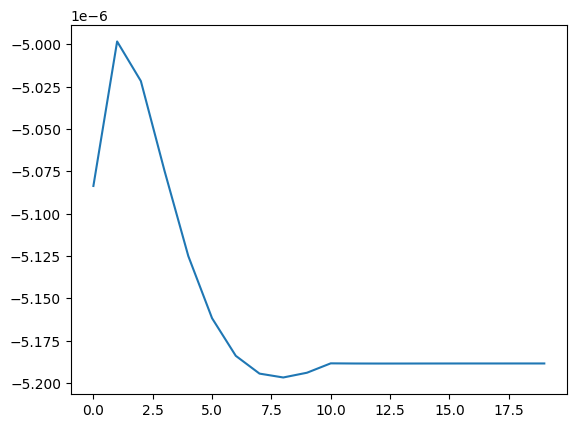

In [55]:
plt.plot(predictions_all)
